## 04. Digit recognition and classification 

In this part step **"4. Classify digit using trained model"** from the project pipeline will be covered. The previous step is taken as the ground truth, i.e. the images of the digits to be classified are fed to the algorithm directly. This can be addressed in the future to improve the need for manual input of the images.

The KERAS model trained in the previous step is loaded and used to classify the digits in the image. This image is fed to the algorithm as the ground truth, i.e. the image that contains the digit to be classified.

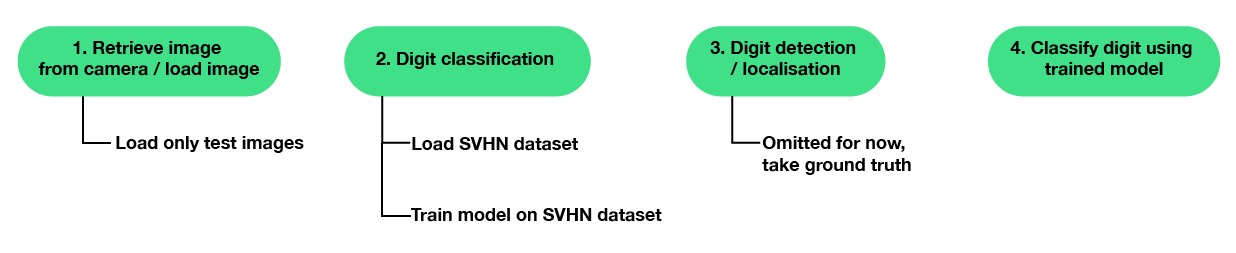

In [1]:
from IPython.display import Image
Image("./pipeline.png")

### Load the trained KERAS model

In [2]:
import tensorflow as tf
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # otherwise there will be an error

model = tf.keras.models.load_model('./2019-19-21.KERAS_model.h5')

### Classify digits

After loading the image, it has to be scaled down to make the digit fit in the 32x32 frame. This could be a result of the digit localization step. I.e. having a sliding window loop through the image with varying size, thus identifying the size of the digit. However, as discussed before, the image to classify is given directly do the algorithm in this project. Giving the model the ground truth images preselected, it classifies the digits in the images.

In [3]:
import cv2
import numpy as np
# function in class SVHNDataset()
def scale_image(self, img, scale_perc):
    """
    Takes an image img (numpy array) and returns a scaled (in percent) down version of the image (as np array.)
    """
#         scale_perc = 40 # percent of original size
    width = int(img.shape[1] * scale_perc / 100)
    height = int(img.shape[0] * scale_perc / 100)
    dim = (width, height)

    scaled_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    return scaled_img

def draw_rectangle(self, img, size, p0, p1, border=5):
    """
    Draws a rectangle with bordersize in the image img at position p0 (vertical), p1 (horizontal). The framesize of the sub-image is size.
    returns the image with the rectangle
    """
    img_t = img.copy()
    img_t[p0:p0+size+border,p1:p1+border] = 255.0 # left side
    img_t[p0:p0+size+border,p1+size:p1+size+border] = 255.0 # right side
    img_t[p0:p0+border,p1:p1+size] = 255.0 # top side
    img_t[p0+size:p0+size+border,p1:p1+size] = 255.0 # bottom side

    return img_t

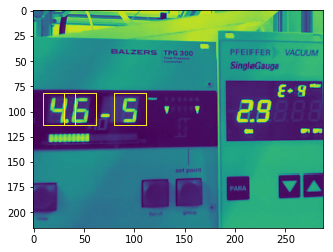

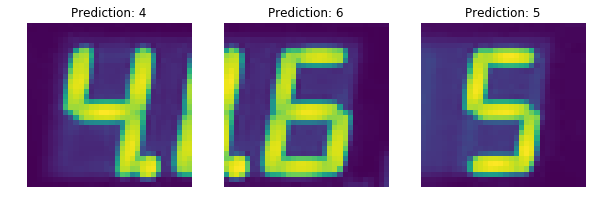

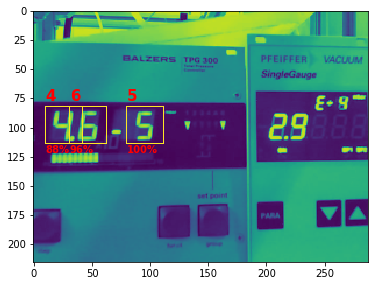

In [23]:
import matplotlib.pyplot as plt
from PressureReadoutObjectStorage import PressureReadoutObjectStorage
import numpy as np

# create object, load test image
pro = PressureReadoutObjectStorage()
img = pro.read_test_image('./test_img.csv')

# scale the image
img = pro.scale_image(img,scale_perc=45)

# ground truth images
p0 = np.asarray([82,82,82])
p1 = np.asarray([10,31,80])
p = np.array([p0,p1])
framesize = 32

# draw the rectangles
img_0 = img.copy()
for ii in range(0,len(p[0])):
    img_0 = pro.draw_rectangle(img_0, 32, p[0,ii], p[1,ii], border=1)
# plot the image
plt.imshow(img_0)
plt.show()

# list of the predictions and probabilities
preds = []
probs = []

fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=len(p[0]))
for ii in range(0,len(p[0])):
    # select frame
    frame = img[p[0,ii]:p[0,ii]+framesize,p[1,ii]:p[1,ii]+framesize].copy()

    ax[ii].axis('off')
    ax[ii].imshow(frame)
    
    # preprocess for keras in right shape
    frame = frame.reshape(-1,32,32,1)

    # get predictions and probabilities
    y_pred = model.predict_classes(frame)[0]
    y_prob = model.predict(frame)[0][y_pred]
    
    # add the predicted class to the list of predictions
    preds.append(y_pred)
    probs.append(y_prob)
    
    ax[ii].set_title(f'Prediction: {y_pred}', loc='center')
    
plt.show()

# plot rectangles, predictions and probalities
fig, ax = plt.subplots(figsize=(6,6))
img_0 = img.copy()
for ii in range(0,len(p[0])):
    img_0 = pro.draw_rectangle(img_0, 32, p[0,ii], p[1,ii], border=1)
    y_prob = int(round(probs[ii]*100))
    
    plt.text(p[1,ii],  p[0,ii]-5, f'{preds[ii]}', color='red', weight = 'heavy', fontsize=15)
    plt.text(p[1,ii],  p[0,ii]+40, f'{y_prob}%', color='red', weight = 'heavy', fontsize=10)
    
# plot the image
plt.imshow(img_0)
plt.savefig('./classified_digits.png', dpi=1200)
plt.show()